LSTM MODEL

In [1]:
# !pip install tensorflow sklearn numpy matplotlib

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import os
import re


#accuracy metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
def load_and_separate_npy(directory):

    feature_files = sorted([f for f in os.listdir(directory) if 'features.npy' in f])
    target_files = sorted([f for f in os.listdir(directory) if 'targets.npy' in f])

    # print(f"Found {len(feature_files)} feature files and {len(target_files)} target files")

    data_by_year = {}
    for feature_file, target_file in zip(feature_files, target_files):
        year_match = re.search(r'(\d{4})\d{4}', feature_file)
        if year_match:
            year = int(year_match.group(1))
            features = np.load(os.path.join(directory, feature_file))
            targets = np.load(os.path.join(directory, target_file))

            #2D arrays check
            if len(features.shape) == 1:
                features = features.reshape(-1, 1)
            if len(targets.shape) == 1:
                targets = targets.reshape(-1, 1)

            # print(f"Loaded data for year {year}: Features shape {features.shape}, Targets shape {targets.shape}")
            data_by_year[year] = (features, targets)
    print("Done")
    return data_by_year

def prepare_data(data_by_year, train_years, val_years, test_year):
    train_features = []
    train_targets = []
    for year in train_years:
        if year in data_by_year:
            features, targets = data_by_year[year]
            train_features.append(features)
            train_targets.append(targets)

    val_features = []
    val_targets = []
    for year in val_years:
        if year in data_by_year:
            features, targets = data_by_year[year]
            val_features.append(features)
            val_targets.append(targets)

    test_features, test_targets = data_by_year[test_year]

    # Concatenate yearly data
    train_features = np.concatenate(train_features, axis=0)
    train_targets = np.concatenate(train_targets, axis=0)
    val_features = np.concatenate(val_features, axis=0)
    val_targets = np.concatenate(val_targets, axis=0)

    return train_features, train_targets, val_features, val_targets, test_features, test_targets

def create_model(input_shape):
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, activation='tanh', return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(3)  # Output layer to predict 3 UTCI values
    ])
    return model

In [45]:
# If data is in Google Drive, use:
DATA_DIR = "data_6-3_array"
# If data is uploaded directly to Colab, use:
# DATA_DIR = "/content/data"

#splitting the data into train,val and test based on year
TRAIN_YEARS = range(2013, 2021)
VAL_YEARS = range(2021, 2024)
TEST_YEAR = 2024


EPOCHS = 500
BATCH_SIZE = 16
LEARNING_RATE = 0.001      #0.001


In [4]:
print("Loading data...")
data_by_year = load_and_separate_npy(DATA_DIR)


print("\nPreparing datasets...")
train_features, train_targets, val_features, val_targets, test_features, test_targets = prepare_data(
    data_by_year, TRAIN_YEARS, VAL_YEARS, TEST_YEAR
)


feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_train_targets = target_scaler.fit_transform(train_targets)

scaled_val_features = feature_scaler.transform(val_features)
scaled_val_targets = target_scaler.transform(val_targets)

scaled_test_features = feature_scaler.transform(test_features)
scaled_test_targets = target_scaler.transform(test_targets)


num_timesteps = 6
num_features = 1
num_targets = 3


X_train = scaled_train_features.reshape(-1, num_timesteps, num_features)
y_train = scaled_train_targets.reshape(-1, num_targets)

X_val = scaled_val_features.reshape(-1, num_timesteps, num_features)
y_val = scaled_val_targets.reshape(-1, num_targets)

X_test = scaled_test_features.reshape(-1, num_timesteps, num_features)
y_test = scaled_test_targets.reshape(-1, num_targets)


print("\nData shapes:")
print(f"Training: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test: X_test: {X_test.shape}, y_test: {y_test.shape}")

Loading data...
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features shape (16, 6), Targets shape (16, 3)
Loaded data for year 2013: Features

In [6]:
print("Creating model...")
model = create_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])
model.summary()

Creating model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 6, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,147 (461.51 KB)

 Trainable params: 118,147 (461.51 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#early stopping if loss doesn't change for 15 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience= 15,    #15
    restore_best_weights=True,
    verbose=1
)
#reduce the learning rate if it stays same for 5 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,    #0.5
    patience=5,   #5
    min_lr=1e-6,       #1e-6
    verbose=1
)


print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Training model...
Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - loss: 0.1857 - mae: 0.3385 - val_loss: 0.1162 - val_mae: 0.2655 - learning_rate: 0.0010
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0914 - mae: 0.2084 - val_loss: 0.0513 - val_mae: 0.1866 - learning_rate: 0.0010
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0583 - mae: 0.2021 - val_loss: 0.0449 - val_mae: 0.1581 - learning_rate: 0.0010
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0545 - mae: 0.1718 - val_loss: 0.0445 - val_mae: 0.1529 - learning_rate: 0.0010
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0559 - mae: 0.1763 - val_loss: 0.0403 - val_mae: 0.1612 - learning_rate: 0.0010
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0494 - mae: 0.1814 - val_loss: 0.0387 - val_mae: 0.1502 - learning_rate: 0.0010
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0477 - mae: 0.1718 - val_loss: 0.0376 - val_mae: 0.1419 - learning_rate: 0.0010


In [8]:
print("\nEvaluating model...")
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")


Evaluating model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0042 - mae: 0.0524 
Test Loss: 0.0043, Test MAE: 0.0530


In [9]:
print("\nEvaluating model...")
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")


Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0041 - mae: 0.0512
Test Loss: 0.0041, Test MAE: 0.0512


In [10]:
print("\nEvaluating model...")
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")


Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0045 - mae: 0.0549
Test Loss: 0.0045, Test MAE: 0.0549


In [11]:
#Since the data is normalized using minmaxscaler, it should be changed to it's original form before checking accuracy (.inverse_transform)

y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)


# mse = np.mean((y_test_inverse - y_pred_inverse) ** 2)
# mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
# mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test, y_pred)
print(f"\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step

Performance Metrics:
MSE: 0.0045
RMSE: 0.0670
MAE: 0.0549
R2: 0.8876


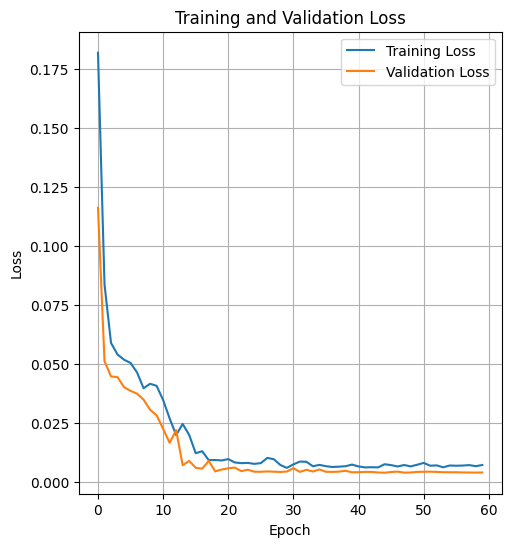

In [12]:
#subplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

LSTM+TRANSFORMER MODEL

In [14]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [15]:
from tensorflow.keras.layers import Input, LSTM, Dropout, MultiHeadAttention, LayerNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_lstm_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM layer
    x = LSTM(128, activation='tanh', return_sequences=True)(inputs)
    x = Dropout(0.3)(x)

    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(x + attention_output)  # Applying normalization to the sum of input and attention output

    # LSTM layer
    x = LSTM(64, activation='tanh', return_sequences=False)(x)
    x = Dropout(0.3)(x)

    # Dense layers
    x = Dense(32, activation='relu')(x)
    outputs = Dense(3)(x)  # Output layer for 3 targets

    return Model(inputs, outputs)

# Create the model
model = create_lstm_transformer_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 6, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_4 (LSTM)                 │ (None, 6, 128)            │          66,560 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 6, 128)            │               0 │ lstm_4[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 6, 128)            │         131,968 │ dropout_4[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 6, 128)            │               0 │ dropout_4[0][0],           │
│                               │                           │                 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 6, 128)            │             256 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_5 (LSTM)                 │ (None, 64)                │          49,408 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 64)                │               0 │ lstm_5[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 32)                │           2,080 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 3)                 │              99 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 250,371 (978.01 KB)

 Trainable params: 250,371 (978.01 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 0.1378 - mae: 0.2824 - val_loss: 0.0538 - val_mae: 0.1770 - learning_rate: 0.0010
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0711 - mae: 0.2064 - val_loss: 0.0413 - val_mae: 0.1762 - learning_rate: 0.0010
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0631 - mae: 0.2096 - val_loss: 0.0347 - val_mae: 0.1504 - learning_rate: 0.0010
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0551 - mae: 0.1778 - val_loss: 0.0412 - val_mae: 0.1549 - learning_rate: 0.0010
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0481 - mae: 0.1622 - val_loss: 0.0317 - val_mae: 0.1358 - learning_rate: 0.0010
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0454 - mae: 0.1558 - val_loss: 0.0226 - val_mae: 0.1218 - learning_rate: 0.0010
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0308 - mae: 0.1383 - val_loss: 0.0173 - val_mae: 0.1018 - learning_rate: 0.0010
Epoch 8/500
8/8 ━━

In [17]:
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0041 - mae: 0.0493 
Test Loss: 0.0048, Test MAE: 0.0529


In [18]:
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0019 - mae: 0.0369
Test Loss: 0.0019, Test MAE: 0.0369


In [19]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0018 - mae: 0.0322
Test Loss: 0.0018, Test MAE: 0.0322


In [20]:
y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step

Performance Metrics:
MSE: 0.0018
RMSE: 0.0429
MAE: 0.0322
R2: 0.9529


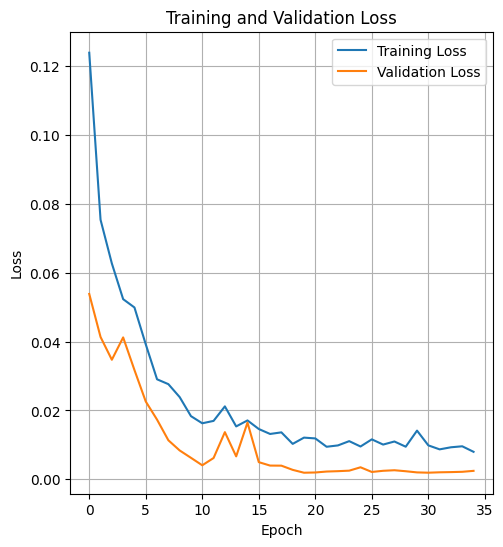

In [21]:
#subplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

GRU

In [22]:
from tensorflow.keras.layers import Input, GRU, Dropout, Dense

In [23]:
def create_gru_model(input_shape):

    inputs = Input(shape=input_shape)


    x = GRU(128, activation='tanh', return_sequences=True)(inputs)
    x = Dropout(0.3)(x)


    x = GRU(64, activation='tanh', return_sequences=False)(x)
    x = Dropout(0.3)(x)


    x = Dense(32, activation='relu')(x)


    outputs = Dense(3)(x)

    return Model(inputs, outputs)

In [24]:
model = create_gru_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 6, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 6, 128)              │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,731 (350.51 KB)

 Trainable params: 89,731 (350.51 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.2063 - mae: 0.3481 - val_loss: 0.0541 - val_mae: 0.1557 - learning_rate: 0.0010
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0604 - mae: 0.1920 - val_loss: 0.0389 - val_mae: 0.1744 - learning_rate: 0.0010
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0463 - mae: 0.1800 - val_loss: 0.0414 - val_mae: 0.1373 - learning_rate: 0.0010
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0446 - mae: 0.1462 - val_loss: 0.0289 - val_mae: 0.1265 - learning_rate: 0.0010
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0369 - mae: 0.1543 - val_loss: 0.0266 - val_mae: 0.1313 - learning_rate: 0.0010
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0397 - mae: 0.1595 - val_loss: 0.0244 - val_mae: 0.1111 - learning_rate: 0.0010
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0292 - mae: 0.1232 - val_loss: 0.0201 - val_mae: 0.1024 - learning_rate: 0.0010
Epoch 8/500
8/8 ━━━

In [26]:
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0035 - mae: 0.0476 
Test Loss: 0.0040, Test MAE: 0.0505


In [27]:
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0032 - mae: 0.0450
Test Loss: 0.0032, Test MAE: 0.0450


In [28]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0030 - mae: 0.0454
Test Loss: 0.0030, Test MAE: 0.0454


In [29]:
y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step

Performance Metrics:
MSE: 0.0030
RMSE: 0.0549
MAE: 0.0454
R2: 0.9239


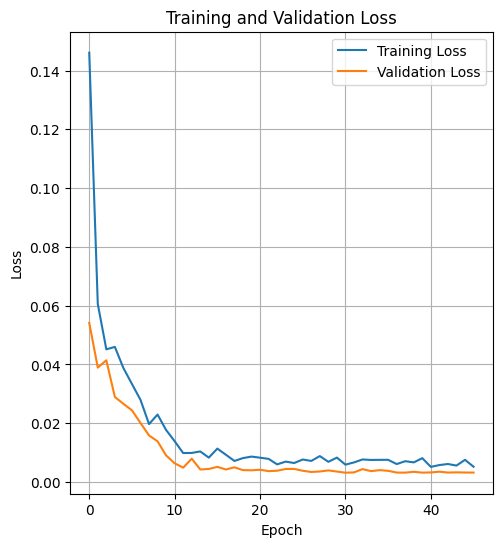

In [30]:
#subplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

GRU+ATTENTION

In [31]:
def create_gru_transformer_model(input_shape):

    inputs = Input(shape=input_shape)


    gru_out = GRU(128, activation='tanh', return_sequences=True)(inputs)
    gru_out = Dropout(0.3)(gru_out)


    attention_out = MultiHeadAttention(num_heads=4, key_dim=64)(gru_out, gru_out)
    attention_out = LayerNormalization()(attention_out)
    attention_out = Dropout(0.3)(attention_out)


    gru_out2 = GRU(64, activation='tanh', return_sequences=False)(attention_out)
    gru_out2 = Dropout(0.3)(gru_out2)


    dense_out = Dense(32, activation='relu')(gru_out2)


    output = Dense(3)(dense_out)


    model = Model(inputs=inputs, outputs=output)
    return model

In [32]:
model = create_gru_transformer_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 6, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_2 (GRU)                   │ (None, 6, 128)            │          50,304 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 6, 128)            │               0 │ gru_2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 6, 128)            │         131,968 │ dropout_9[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 6, 128)            │             256 │ multi_head_attention_1[0]… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 6, 128)            │               0 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_3 (GRU)                   │ (None, 64)                │          37,248 │ dropout_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 64)                │               0 │ gru_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 32)                │           2,080 │ dropout_12[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 3)                 │              99 │ dense_8[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 221,955 (867.01 KB)

 Trainable params: 221,955 (867.01 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - loss: 0.1686 - mae: 0.3171 - val_loss: 0.0559 - val_mae: 0.1718 - learning_rate: 0.0010
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0817 - mae: 0.2217 - val_loss: 0.0418 - val_mae: 0.1514 - learning_rate: 0.0010
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0771 - mae: 0.2066 - val_loss: 0.0393 - val_mae: 0.1560 - learning_rate: 0.0010
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0562 - mae: 0.1808 - val_loss: 0.0404 - val_mae: 0.1618 - learning_rate: 0.0010
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0501 - mae: 0.1727 - val_loss: 0.0418 - val_mae: 0.1543 - learning_rate: 0.0010
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0695 - mae: 0.2048 - val_loss: 0.0411 - val_mae: 0.1547 - learning_rate: 0.0010
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0468 - mae: 0.1581 - val_loss: 0.0354 - val_mae: 0.1473 - learning_rate: 0.0010
Epoch 8/500
8/8 ━━━

In [34]:
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0040 - mae: 0.0492 
Test Loss: 0.0051, Test MAE: 0.0547


In [35]:
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0024 - mae: 0.0391
Test Loss: 0.0024, Test MAE: 0.0391


In [36]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0019 - mae: 0.0365
Test Loss: 0.0019, Test MAE: 0.0365


In [37]:
y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)  # (predicted-true)/total_data_points
r2 = r2_score(y_test, y_pred)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step

Performance Metrics:
MSE: 0.0019
RMSE: 0.0437
MAE: 0.0365
R2: 0.9520


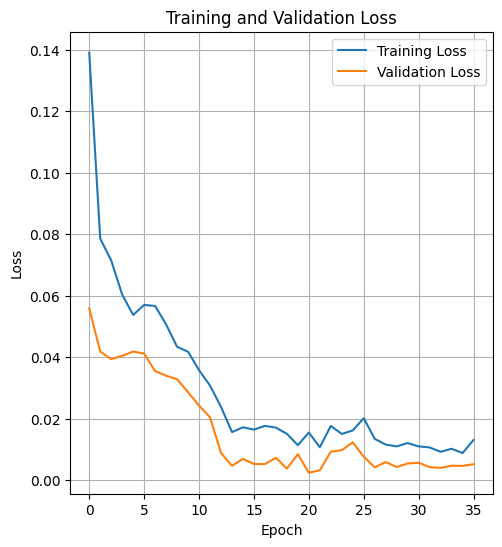

In [38]:
#subplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

INTERPRETATION

In [40]:
prediction_save_path = "predicted_next_year_utci.npy"
np.save(prediction_save_path, y_pred_inverse)
print(f"\nPredicted UTCI for next year saved at {prediction_save_path}")


Predicted UTCI for next year saved at predicted_next_year_utci.npy


In [41]:
prediction_save_path = "actual_next_year_utci.npy"
np.save(prediction_save_path, y_test_inverse)
print(f"\nActual UTCI for next year saved at {prediction_save_path}")


Actual UTCI for next year saved at actual_next_year_utci.npy


In [42]:
import pandas as pd
npy_file_pred = 'predicted_next_year_utci.npy'
npy_file_true = 'actual_next_year_utci.npy'
data_pred = np.load(npy_file_pred)
data_true = np.load(npy_file_true)

data_pred_flat = data_pred.flatten()
data_true_flat = data_true.flatten()

print(data_pred_flat.shape)
print(data_true_flat.shape)
print(data_pred)
print(data_pred_flat)
print(data_true)
print(data_true_flat)
combined_data = np.column_stack((data_pred_flat, data_true_flat))

df = pd.DataFrame(combined_data, columns=['Predicted', 'Actual'])

df.to_csv('predictions_vs_actuals.csv', index=False)

print("CSV file has been created.")

(48,)
(48,)
[[35.484188 35.3619   34.50581 ]
 [35.99174  35.65677  34.66041 ]
 [36.082447 35.470474 34.376827]
 [35.522068 34.566128 33.43418 ]
 [34.627716 33.38767  32.258617]
 [33.118855 31.607048 30.525764]
 [31.511467 29.884935 28.943727]
 [30.18707  28.594976 28.50793 ]
 [29.646452 28.49346  28.49875 ]
 [29.18335  28.358782 28.33532 ]
 [28.906895 28.196018 27.984045]
 [28.736664 28.094976 27.693527]
 [28.696596 28.356386 27.718481]
 [28.682825 28.424982 27.767483]
 [28.559025 28.382057 27.706978]
 [28.397377 28.289637 27.621515]]
[35.484188 35.3619   34.50581  35.99174  35.65677  34.66041  36.082447
 35.470474 34.376827 35.522068 34.566128 33.43418  34.627716 33.38767
 32.258617 33.118855 31.607048 30.525764 31.511467 29.884935 28.943727
 30.18707  28.594976 28.50793  29.646452 28.49346  28.49875  29.18335
 28.358782 28.33532  28.906895 28.196018 27.984045 28.736664 28.094976
 27.693527 28.696596 28.356386 27.718481 28.682825 28.424982 27.767483
 28.559025 28.382057 27.706978 28.3

In [43]:
df=pd.read_csv("predictions_vs_actuals.csv")
# df

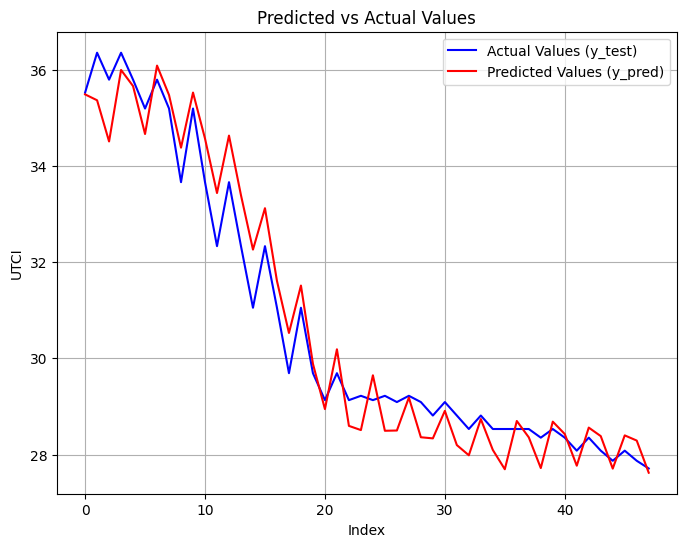

In [44]:
y_pred = df['Predicted']
y_test = df['Actual']
# print(y_pred,y_test)

plt.figure(figsize=(8, 6))

plt.plot(y_test, label='Actual Values (y_test)', color='blue', linestyle='-')
plt.plot(y_pred, label='Predicted Values (y_pred)', color='red', linestyle='-')


plt.title('Predicted vs Actual Values')
plt.xlabel('Index')
plt.ylabel('UTCI')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()